In [21]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax

In [78]:
pd.DataFrame(ts)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,426.000000,429.5,426.000000,426.000000,426.0,419.0,419.0,419.000000,419.0,419.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,423.666667,419.0,419.0,419.000000,411.000000,411.0,411.0,408.333333,400.0,396.0
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,405.000000,405.0,405.0,405.000000,405.000000,412.0,419.0,419.000000,419.0,419.0
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,356.000000,426.0,423.666667,...,422.500000,422.5,419.0,428.333333,424.600000,426.0,429.5,419.000000,426.0,419.0
4,396.000000,396.0,396.000000,398.333333,399.5,413.0,411.0,411.000000,411.0,412.200000,...,429.000000,429.0,429.0,434.000000,444.000000,444.0,444.0,441.750000,446.0,439.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,403.666667,419.0,419.000000,419.000000,433.0,433.0,433.0,429.500000,433.0,433.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
160,433.000000,433.0,423.666667,429.500000,429.5,433.0,426.0,428.333333,429.5,433.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
161,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,419.000000,419.0,419.0,419.000000,409.666667,405.0,405.0,408.000000,413.0,404.5
162,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,419.000000,419.0,419.0,419.000000,419.000000,419.0,419.0,426.000000,422.5,426.0


In [22]:
data=pd.read_csv("C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/datatraining.txt")
data.index=pd.to_datetime(data.date, format='%Y-%m-%d %H:%M:%S')
data["day_night"]=0
data.loc[(data.index.hour >= 7)&(data.index.hour <= 19), ["day_night"]]=1
data.sort_index(inplace=True)
light=data[["Light", "day_night"]]
temp=data[["Temperature", "day_night"]]
hum=data[["Humidity", "day_night"]]
data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day_night
date,,,,,,,,
2015-02-04 17:51:00,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,1
2015-02-04 17:51:59,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,1
2015-02-04 17:53:00,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,1
2015-02-04 17:54:00,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,1
2015-02-04 17:55:00,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,1


In [23]:
# split time series in 60 minutes series with on offset of 20 minutes

ts_light=[]
ts_light_labels=[]
for i in range(0,len(light),20):
    try:
        if len(light.iloc[i:i+60,0].to_list())==60:
            ts_light.append(light.iloc[i:i+60,0].to_list())
            ts_light_labels.append(light.iloc[i:i+60,1].mean())
        else:
            pass
    except:
        pass
ts_light_labels=[1 if x>0.65 else 0 for x in ts_light_labels]

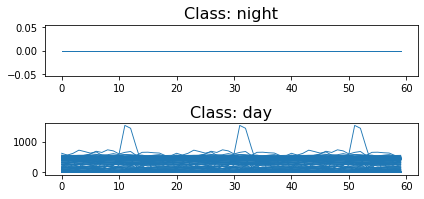

In [24]:
ts_labels=np.array(ts_light_labels)
ts=np.array(ts_light)

plt.figure()
for i, classe in enumerate(['night', 'day']):
    plt.subplot(3, 1, i + 1)
    for x in ts[ts_labels == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.9)
plt.show()

In [25]:
ts_no_zeros=[]
ts_no_zeros_labels=[]
ts_zeros=[]
ts_zeros_labels=[]
for i, x in enumerate(ts):
    if x.mean()==0:
        ts_zeros.append(x)
        ts_zeros_labels.append(ts_labels[i])
    else:
        ts_no_zeros.append(x)
        ts_no_zeros_labels.append(ts_labels[i])

In [26]:
ts_labels=np.array(ts_no_zeros_labels)
ts=np.array(ts_no_zeros)

In [27]:
scaler = TimeSeriesScalerMinMax()
X = scaler.fit_transform(ts).reshape(ts.shape[0], ts.shape[1])

X = np.append(X, ts_zeros, 0)
y = np.append(ts_no_zeros_labels, ts_zeros_labels, 0)

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Feature-based Classifier

In [30]:
import scipy.stats as stats

In [31]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [38]:
X_train3 = np.array([list(calculate_features(x).values())[:-3] for x in X_train])

C:\Users\xhuli\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [39]:
X_test3 = np.array([list(calculate_features(x).values())[:-3] for x in X_test])

C:\Users\xhuli\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9098360655737705
F1-score [0.91729323 0.9009009 ]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        61
           1       1.00      0.82      0.90        61

    accuracy                           0.91       122
   macro avg       0.92      0.91      0.91       122
weighted avg       0.92      0.91      0.91       122



# Time Series Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
clf = KNeighborsClassifier(n_neighbors=2, weights='uniform')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9016393442622951
F1-score [0.91044776 0.89090909]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        61
           1       1.00      0.80      0.89        61

    accuracy                           0.90       122
   macro avg       0.92      0.90      0.90       122
weighted avg       0.92      0.90      0.90       122



In [52]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9016393442622951
F1-score [0.91044776 0.89090909]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        61
           1       1.00      0.80      0.89        61

    accuracy                           0.90       122
   macro avg       0.92      0.90      0.90       122
weighted avg       0.92      0.90      0.90       122



# CNN Classifier

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization

In [58]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [59]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  60
N. LABELS:  2


In [60]:
cnn = build_simple_cnn(n_timesteps, n_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [61]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 53, 16)            144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 53, 16)            64        
_________________________________________________________________
activation_1 (Activation)    (None, 53, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 49, 32)            2592      
_________________________________________________________________
batch_normalization_2 (Batch (None, 49, 32)            128       
_________________________________________________________________
activation_2 (Activation)    (None, 49, 32)           

In [62]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [63]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

In [64]:
history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Instructions for updating:
Use tf.cast instead.
Train on 226 samples, validate on 57 samples
Epoch 1/5
226/226 [==============================] - 1s 4ms/step - loss: 0.6346 - accuracy: 0.4027 - val_loss: 0.6606 - val_accuracy: 0.4912
Epoch 2/5
226/226 [==============================] - 0s 588us/step - loss: 0.5123 - accuracy: 0.8451 - val_loss: 0.6650 - val_accuracy: 0.9298
Epoch 3/5
226/226 [==============================] - 0s 583us/step - loss: 0.4569 - accuracy: 0.8850 - val_loss: 0.6756 - val_accuracy: 0.9123
Epoch 4/5
226/226 [==============================] - 0s 487us/step - loss: 0.3894 - accuracy: 0.8850 - val_loss: 0.6840 - val_accuracy: 0.8070
Epoch 5/5
226/226 [==============================] - 0s 499us/step - loss: 0.3468 - accuracy: 0.8938 - val_loss: 0.6895 - val_accuracy: 0.5614


In [65]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5983606557377049
F1-score [0.71345029 0.32876712]
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        61
           1       1.00      0.20      0.33        61

    accuracy                           0.60       122
   macro avg       0.78      0.60      0.52       122
weighted avg       0.78      0.60      0.52       122



In [66]:
cnn.evaluate(X_test_cnn, y_test)

122/122 [==============================] - 0s 106us/step


[0.6890321940672203, 0.5983606576919556]

# LSTM Classifier

In [67]:
from keras.layers import LSTM

In [68]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [69]:
lstm = build_lstm(n_timesteps, n_outputs)

In [70]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 280,770
Trainable params: 280,770
Non-trainable params: 0
_________________________________________________________________


In [72]:
history_lstm = cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

Train on 226 samples, validate on 57 samples
Epoch 1/10
226/226 [==============================] - 0s 583us/step - loss: 0.3533 - accuracy: 0.8850 - val_loss: 0.6906 - val_accuracy: 0.5614
Epoch 2/10
226/226 [==============================] - 0s 578us/step - loss: 0.3123 - accuracy: 0.8938 - val_loss: 0.6919 - val_accuracy: 0.5088
Epoch 3/10
226/226 [==============================] - 0s 579us/step - loss: 0.3179 - accuracy: 0.8938 - val_loss: 0.6923 - val_accuracy: 0.5088
Epoch 4/10
226/226 [==============================] - 0s 560us/step - loss: 0.3368 - accuracy: 0.8894 - val_loss: 0.6926 - val_accuracy: 0.5088
Epoch 5/10
226/226 [==============================] - 0s 496us/step - loss: 0.3274 - accuracy: 0.8894 - val_loss: 0.6926 - val_accuracy: 0.5088
Epoch 6/10
226/226 [==============================] - 0s 520us/step - loss: 0.3213 - accuracy: 0.8938 - val_loss: 0.6926 - val_accuracy: 0.5088
Epoch 7/10
226/226 [==============================] - 0s 528us/step - loss: 0.3050 - accura

In [73]:
y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9098360655737705
F1-score [0.91729323 0.9009009 ]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        61
           1       1.00      0.82      0.90        61

    accuracy                           0.91       122
   macro avg       0.92      0.91      0.91       122
weighted avg       0.92      0.91      0.91       122



In [74]:
lstm.evaluate(X_test_cnn, y_test)

122/122 [==============================] - 0s 2ms/step


[0.6894058643794451, 0.9098360538482666]